# Geospatial Data Analysis fundamentals
CEWA599  
February 1, 2019

# Goals
* Review some fundamental concepts that are common to most geospatial analysis
* Explore coordinate systems, projections and transformations, geometry types
* Create more sophisticated visualizations involving multiple layers and data types

## Outline

1. Spatial reference systems  
    1.1 Horizontal coordinate system  
    1.2 Vertical coordinate system (datum)
    1.3 Formats:
        - proj string
        - EPSG code
        - Wkt
    1.4 Necessary information for transformations
2. Geometries  
    2.1 Points, Lines, Polygons  
    2.2 Creating geometries
3. Dataset properties: extent
4. Coordinate transformations, reprojection
5. Basic vector operations

## Key modules and packages
* geopandas - high-level vector processing (most of what we'll do)
    * fiona - handles input/output
        * ogr
        * osr
        * [proj](https://proj4.org/)
    * shapely - underlying geometry manipulation
        * geos

# Exercises

## Import necessary modules

In [1]:
#%matplotlib widget
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import fiona
plt.rcParams['figure.figsize'] = [10, 8]

# Part 1: Projections

There are many excellent references out there about coordinate systems and map projections.  I'm not going to try to reproduce here.  If you're relatively new to all of this, please review:
* http://resources.esri.com/help/9.3/arcgisengine/dotnet/89b720a5-7339-44b0-8b58-0f5bf2843393.htm
* http://maps.unomaha.edu/Peterson/gis/notes/MapProjCoord.html
* http://downloads2.esri.com/support/documentation/ao_/710Understanding_Map_Projections.pdf
* https://courses.washington.edu/gis250/lessons/projection/

## Load world country polygons (bundled with geopandas)

In [2]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

## Check the coordinate reference system (crs)

In [3]:
world.crs

{'init': 'epsg:4326'}

## Look up this EPSG code online (and burn it into your brain)
* What is it?

In [4]:
#fiona.crs.to_string(fiona.crs.from_epsg(4326))

## Plot the GeoDataFrame using the built-in geopandas plot function with default settings

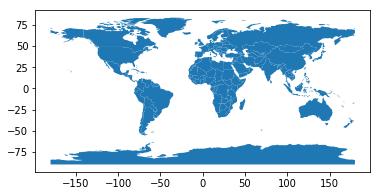

In [5]:
world.plot()

## Define a custom projection centered on the (self-proclaimed) "Center of the Universe"
### Fremont, Seattle, WA, Earth
* https://www.atlasobscura.com/places/center-of-the-universe-sign
* You'll probably need to look up some coordinates on the web
* Create a proj4 string (make sure you use sufficient precision for your decimal)
* Choose a simple projection that accepts a center latitude and center longitude (e.g., orthographic)

In [6]:
cotu_coord = (47.6062, -122.3321)
local_proj_str = '+proj=ortho +lat_0=%0.7f +lon_0=%0.7f +datum=WGS84 +units=m +no_defs ' % cotu_coord

## Transform the world!
* Use GeoPandas to reproject the world GeoDataFrame to your local projection, centered on the center of the universe, reducing our beautiful [multidimensional universe](http://mentalfloss.com/article/501926/how-many-dimensions-are-there) to a 2D plot
* Note where the origin (0,0) is located
* See documentation here: http://geopandas.org/projections.html

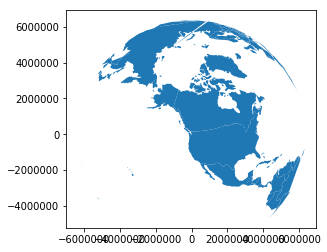

In [7]:
world_cotu = world.to_crs(local_proj_str)
ax = world_cotu.plot()

## Wow, that was easy!
* Let's experiment with a few additional projections
* Try the following EPSG codes:
    * EPSG:3031 - South Polar Stereographic (see if you can find Antarctica)
    * EPSG:3857 - web mercator (format for most tiles like Google Satellite)
    * One or more additional EPSG codes of your choosing

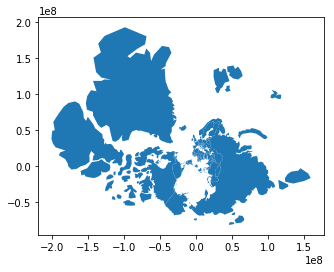

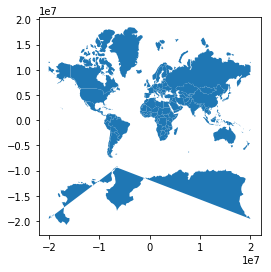

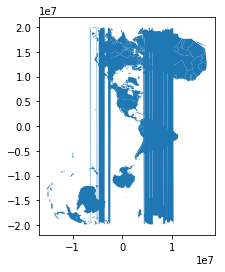

In [8]:
epsg_list = [3031, 3857, 32613]
for epsg in epsg_list:
    world.to_crs('+init=epsg:%i' % epsg).plot()

## OK, that was also easy, but some countries look wonky
* Note some polygons (countries) that cross the antimeridian (-180°/+180° lon) or one of the poles (+90° or -90° lat, like, say Antarctica) may not render correctly
    * If using a regional projection for regional analysis (e.g., Western U.S.), you probably wouldn't want to include polygons from the other side of the planet anyway. If you have a global dataset, can extract only polygons of interest before reprojecting.
    * Alternative approach is to split problematic polygons before reprojecting:
        * https://shapely.readthedocs.io/en/stable/manual.html#shapely.ops.split
        * https://github.com/Toblerity/Shapely/issues/495

Try isolating polygons from North America in the `world` GeoDataFrame, and rerun your projection tests

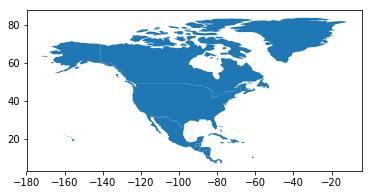

In [9]:
world_na = world[world['continent'] == 'North America']
world_na.plot()

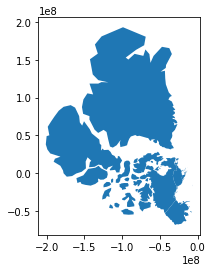

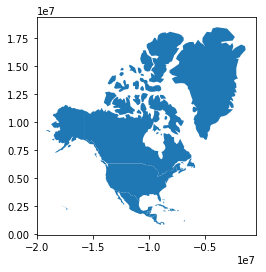

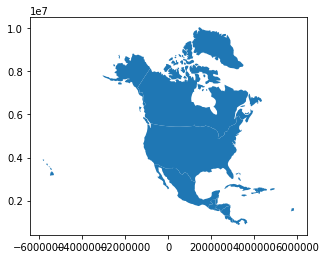

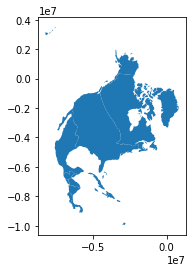

In [10]:
epsg_list = [3031, 3857, 32613, 3413]
for epsg in epsg_list:
    world_na.to_crs('+init=epsg:%i' % epsg).plot()

## That looks better
* Check out: https://bl.ocks.org/syntagmatic/ba569633d51ebec6ec6e and https://www.jasondavies.com/maps/transition/ for interactive visualizations
* Also, https://xkcd.com/977/

## Global Projection Tradeoffs - Tissot example

We're not going to get into cartopy right now, but I created the following function to show the classic [Tissot indicatrix](https://en.wikipedia.org/wiki/Tissot%27s_indicatrix) example, which help visualize distortion in different projections

In [11]:
#Function to create cartopy plot with Tissot circles for input crs

def makeplot(crs):
    fig, ax = plt.subplots(subplot_kw={'projection': crs})
    lons = range(-180, 180, 20)
    lats = range(-90, 90, 20)
    ax.coastlines()
    #ax.stock_img()
    ax.tissot(facecolor='orange', alpha=0.4, rad_km=500, lons=lons, lats=lats)
    ax.set_title('%s\n%s' % (crs, crs.proj4_init), fontsize=8)
    ax.set_global()
    #ax.add_geometries(world_proj['geometry'], crs=crs)
    return ax

/opt/conda/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:632: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f2c0164e938> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))
/opt/conda/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:632: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f2c0164eaf0> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))
/opt/conda/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:632: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f2c0164eca8> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))
/opt/conda/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:632: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f2c0164ee60> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))
/opt/conda/lib/python3.6/site-packages/cartopy/mpl/geoaxes.p

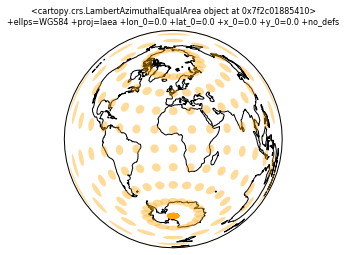

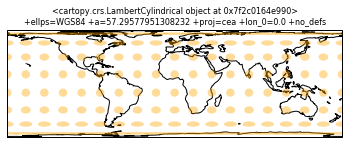

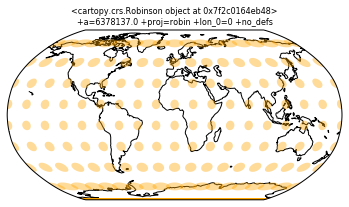

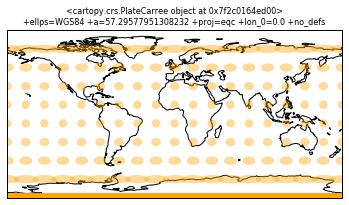

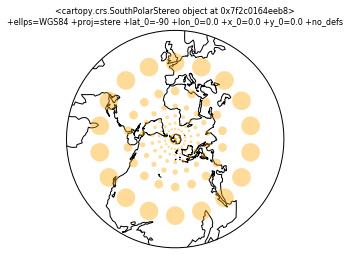

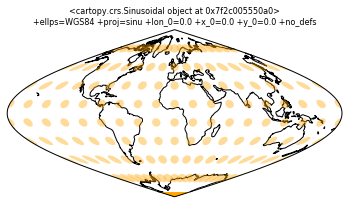

In [12]:
import cartopy.crs as ccrs

makeplot(ccrs.LambertAzimuthalEqualArea())
makeplot(ccrs.LambertCylindrical())
makeplot(ccrs.Robinson())
makeplot(ccrs.PlateCarree())
makeplot(ccrs.SouthPolarStereo())
makeplot(ccrs.Sinusoidal())

## OK, those are nice.  Now look at them.
* Which projection has greatest area distortion?  How can you tell?
* Which has greatest azimuthal distortion?




# Part 2: ICESat may be dead, but the points live on...
* Let's continue to play with the CONUS GLAS csv dataset
* But this time, let's move beyond basic NumPy and Pandas and start using GeoPandas

## Load the csv into a Pandas DataFrame

In [13]:
glas_fn = '../03_NumPy_Pandas_Matplotlib/GLAH14_tllz_conus_lulcfilt_demfilt.csv'
glas_df = pd.read_csv(glas_fn)

In [14]:
glas_df.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31


## Convert to a GeoDataFrame

https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html

Run a quick `head()` to make sure everything looks good

In [15]:
glas_df['geometry'] = list(zip(glas_df['lon'], glas_df['lat']))
glas_df['geometry'] = glas_df['geometry'].apply(Point)
glas_gdf = gpd.GeoDataFrame(glas_df)
glas_df.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,geometry
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31,POINT (-105.356562 44.157897)
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31,POINT (-105.358116 44.150175)
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31,POINT (-105.358427 44.148632)
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31,POINT (-105.358738 44.147087)
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31,POINT (-105.359048 44.145542)


## Set the coordinate reference system
* http://geopandas.org/projections.html
* Probably easiest to use an EPSG code for geographic lat/lon coordinate system here
* Note that you can also define this during the initial GeoDataFrame creation

In [16]:
glas_gdf.crs = {'init' :'epsg:4326'}

## Plot the points using built-in geopandas plot function
* Check the documentation
* Color points by 'glas_z'
* Set point size appropriately
* Add a colorbar

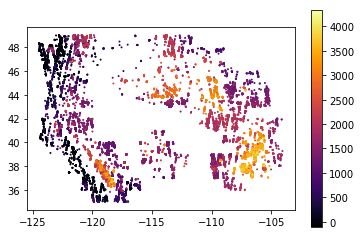

In [17]:
glas_gdf.plot(column='glas_z', cmap='inferno', markersize=1, legend=True)

## Convert the points to a projected coordinate system
* Use an appropriate Universal Transverse Mercator (UTM) zone
* Store the output as a new GeoDataFrame

In [18]:
utm_crs = {'init': 'epsg:32611'}
glas_gdf_utm = glas_gdf.to_crs(utm_crs)

## Create a new plot of the reprojected points
* Note the aspect ratio

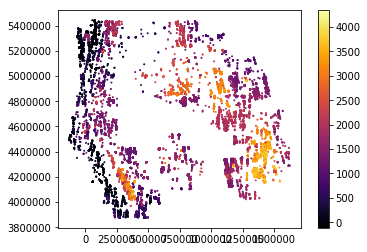

In [19]:
ax = glas_gdf_utm.plot(column='glas_z', cmap='inferno', markersize=1, legend=True)
#ax.set_aspect('equal')
#ax.grid()

## Excellent, but what did we just do?

Under the hood, GeoPandas used fiona and the proj library to transform each point from one coordinate system to another coordinate system.  

You've all done this kind of thing before: https://en.wikipedia.org/wiki/List_of_common_coordinate_transformations

In 2D, transforming (x,y) coordinates between different projections (e.g., UTM vs. Albers Equal Area) on the same reference ellipsoid is pretty straightforward.  Things start to get more complicated when you include different ellipsoid models, horizontal/vertical datums, etc.  Oh, also the Earth's surface is not static - plate tectonics make everything more complicated, as time becomes important, and transformations must include a "kinematic" component.  

Fortunately, the PROJ library (https://proj4.org/about.html) has generalized much of the complicated math for geodetic coordinate transformations.  It's been under development since the 1980s, and our understanding of the Earth's shape and plate motions has changed dramatically in that time period.  So, still pretty complicated, and there are different levels of support/sophistication in the tools/libraries that use PROJ (like fiona or GeoPandas).

We aren't going to get into the details here, but quickly take a look at the Transformations section here to get a sense of how this is actually accomplished: https://proj4.org/operations/index.html

## Add new columns to the GeoDataFrame to store the projected x and y coordinates
* Note: don't _need_ to do this, as the geometry column already stores this information, but sometimes you want to preserve these if you're going to export or manipulate outside of GeoPandas
* This should be pretty simple - no need for loops or a custom function here (hint: use the x and y attributes of the POINT geometry column)

In [20]:
glas_gdf_utm['utm_x'] = glas_gdf_utm['geometry'].x
glas_gdf_utm['utm_y'] = glas_gdf_utm['geometry'].y

In [21]:
glas_gdf_utm.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,geometry,utm_x,utm_y
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31,POINT (1431183.069745451 4955789.786789796),1.431183e+06,4.955790e+06
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31,POINT (1431181.914650238 4954913.88229024),1.431182e+06,4.954914e+06
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31,POINT (1431181.639258059 4954738.854527334),1.431182e+06,4.954739e+06
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31,POINT (1431181.393744648 4954563.604482028),1.431181e+06,4.954564e+06
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31,POINT (1431181.226227158 4954388.36587402),1.431181e+06,4.954388e+06


## Save reprojected output to disk
* Use fiona to get a list of available file type drivers for output

In [22]:
fiona.supported_drivers

{'ARCGEN': 'r',
 'AeronavFAA': 'r',
 'BNA': 'raw',
 'CSV': 'raw',
 'DGN': 'raw',
 'DXF': 'raw',
 'ESRI Shapefile': 'raw',
 'GML': 'raw',
 'GPKG': 'rw',
 'GPSTrackMaker': 'raw',
 'GPX': 'raw',
 'GeoJSON': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'OpenFileGDB': 'r',
 'PCIDSK': 'r',
 'S57': 'r',
 'SEGY': 'r',
 'SUA': 'r'}

## How to choose a format?
* You've all used shapefiles in the past.  This is a legacy format, though it is still widely used.
* http://switchfromshapefile.org/
* Better options these days are Geopackage (GPKG) or in some cases, plaintext GeoJSON
* Use Geopackage for this exercise
* Now that you've made an informed decision, pick a filename and use the Geopandas `to_file()` method
    * Make sure you properly specify filename with extension and the `driver` option
    * Note: Writing out may take a minute, and may produce an intermediate '.gpkg-journal' file

In [23]:
out_fn='./conus_glas_utm_32611.gpkg'
#glas_gdf_utm.to_file(out_fn, driver='GPKG')

## :tada:

You can now directly load this gpkg file in any GIS, without defining a coordinate system or dealing with your original csv.  

Try it! Right-click on file in the file browser to the left of the JupyterLab interface, Download.  Then open in QGIS on your local machine.

You can also load this file directly into geopandas in the future using the `read_file()` method, without having to do any of the processing above.

## A quick aside: `gdalsrsinfo`

We covered basic command line usage in Week 01.  We haven't discussed yet, but you will soon realize the power of the GDAL/OGR command-line utilities for batch data processing and quick geodata inspection (we will discuss more during vector/raster modules).

One of these utilties, `gdalsrsinfo`, is great for quickly inspecting datasets, and dealing with srs and converting between different formats (proj4 string, EPSG, etc).

Open a new terminal, navigate to the directory where you just created the output file.  Run:
* `gdalsrsinfo filename.gpkg`
* `gdalsrsinfo EPSG:32610`

By default, this will export a proj4 string and WKT for the crs.  You can also output different formats `gdalsrsinfo -h`

Note that you can also run shell commands directly within a Jupyter notebook using the `!cmd` syntax.  Try this here:

In [24]:
!gdalsrsinfo conus_glas_utm_32611.gpkg


PROJ.4 : +proj=utm +zone=11 +datum=WGS84 +units=m +no_defs 

OGC WKT :
PROJCS["WGS 84 / UTM zone 11N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-117],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32611"]]



# Part 3: Let's mix some points and polygons

## Get polygons for US States

Hmmm, let's see.  Two choices:
1. We could go to ESRI or the U.S. Census website, identify and download a shapefile, unzip 4+ files, copy/paste the appropriate \*.shp filename into the notebook.  Wait, how can I download on a remote server?  OK, maybe run something like `wget http://...`, unzip, provide absolute path  
*- OR -*
2. Give geopandas a url string that points to a GeoJSON file somewhere, and read dynamically

Yeah, let's go with #2

Let's use the US States 5M GeoJSON here: http://eric.clst.org/tech/usgeojson/

If you are unfamiliar, take a moment to read about GeoJSON: https://en.wikipedia.org/wiki/GeoJSON

Take a moment to look at the 5M file contents using a text editor.  Note organization structure.  How does this compare to, say, a Python dictionary object? 

Read in the file with GeoPandas and inspect to confirm that things look good

In [25]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)
states_gdf

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US01,01,Alabama,,50645.326,"(POLYGON ((-88.124658 30.28364, -88.0868119999..."
1,0400000US02,02,Alaska,,570640.950,"(POLYGON ((-166.10574 53.988606, -166.075283 5..."
2,0400000US04,04,Arizona,,113594.084,"POLYGON ((-112.538593 37.000674, -112.534545 3..."
3,0400000US05,05,Arkansas,,52035.477,"POLYGON ((-94.042964 33.019219, -94.043036 33...."
4,0400000US06,06,California,,155779.220,"(POLYGON ((-122.421439 37.869969, -122.421341 ..."
5,0400000US08,08,Colorado,,103641.888,"POLYGON ((-106.190554 40.997607, -106.061181 4..."
6,0400000US09,09,Connecticut,,4842.355,"POLYGON ((-71.79924200000001 42.008065, -71.79..."
7,0400000US10,10,Delaware,,1948.543,"(POLYGON ((-75.564927 39.583248, -75.576271000..."
8,0400000US11,11,District of Columbia,,61.048,"POLYGON ((-77.03859799999999 38.791513, -77.03..."
9,0400000US12,12,Florida,,53624.759,"(POLYGON ((-82.821585 27.964443, -82.829801 27..."


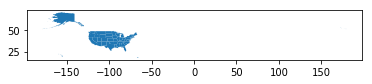

In [26]:
states_gdf.plot()

states_gdf.plot

In [27]:
states_gdf.crs

{'init': 'epsg:4326'}

## Extract the geometry object for Washington
* Use the state 'NAME' value to isolate the GeoDataFrame entry
* Pull out the geometry object and assign to a variable called `wa_geom`

In [28]:
wa_gdf = states_gdf[states_gdf['NAME'] == 'Washington']
wa_geom = wa_gdf.iloc[0].geometry

## Inspect the Washington geometry object
Take a look at the first few sections of the shapely manual: https://shapely.readthedocs.io/en/stable/manual.html
* What happens when you pass the geometry object to `print()`? (clear the output and describe what happened)
* What happens when you execute a notebook cell containing only the geometry object variable name? Oooh.
* What are the geometry bounds?  What does each of these four values represent?  Note the order.
* What is the geometry type?
* How many individual polygons are contained in the geometry?  If more than one, why?

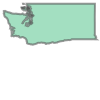

In [29]:
wa_geom

In [30]:
wa_geom.bounds

(-124.733174, 45.543541, -116.915989, 49.002494)

In [31]:
wa_geom.geom_type

'MultiPolygon'

In [32]:
len(wa_geom)

12

## Cracking open the geometry collection
* Compute the area of each individual polygon (OK to use native units of degrees)
* Isolate and render the polygons that have min and max area
* Render the convex hull of the polygon with max area
* Compute the difference in area between the largest polygon and the convex hull
* Render and `print()` the polygon with min area. Note the pairs of Point coordinates for the vertices
* How many vertices are in each polygon?
    * Hint, can extract list of point tuples using `poly.exterior.coords[:]`
    * Take a look at the coordinates of the smallest polygon
        * What do you notice about the first and last coordinate?

In [33]:
poly_area = [x.area for x in wa_geom]
print(poly_area)

[0.056087388280999705, 0.012821709933499612, 0.0029648812429996702, 0.0015208536634998505, 0.07596709677449924, 0.0026517311014998923, 0.001587073559499895, 0.00267134936649981, 0.0029710214090000776, 0.0004883493424999956, 0.00021297008200007306, 20.785268835375447]


In [34]:
import numpy as np
maxidx = np.argmax(poly_area)
minidx = np.argmin(poly_area)

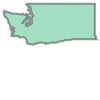

In [35]:
poly_max = wa_geom[maxidx]
poly_max

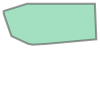

In [36]:
poly_max.convex_hull

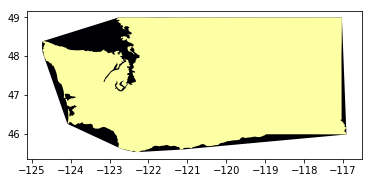

In [88]:
chull_gs = gpd.GeoSeries([wa_geom[maxidx].convex_hull,wa_geom[maxidx]])
chull_gs.plot(cmap='inferno')

POLYGON ((-122.334524 48.018916, -122.328343 48.021335, -122.321721 48.019977, -122.303455 48.005603, -122.306629 48.004397, -122.326115 48.010295, -122.334524 48.018916))


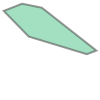

In [38]:
print(wa_geom[minidx])
poly_min = wa_geom[minidx]
poly_min

In [39]:
# Note -1 to remove repeated coord
len(poly_max.exterior.coords[:]) - 1

1365

In [40]:
len(poly_min.exterior.coords[:]) - 1

6

## Compute area for all states in the GeoDataFrame
* Area values should be in km<sup>2</sup>
    * Hint: Is this consistent with the original units of your state GeoDataFrame?  What might you need to do to the GeoDataFrame before you proceed?
* Compare your values with the CENSUSAREA values
    * Calculate differences as a percentage of the CENSUSAREA 
    * Note: CENSUSAREA is in square miles (sigh)
* Do your numbers agree?  If not, any idea why not?

In [60]:
#Use utm here, area differences will be huge at greater distances from the zone clon
states_gdf_utm = states_gdf.to_crs(utm_crs)

In [61]:
states_gdf_utm['myarea'] = states_gdf_utm.area/1E6
states_gdf_utm['CENSUSAREA_km2'] = states_gdf_utm['CENSUSAREA']*2.58999
states_gdf_utm['area_diff'] = states_gdf_utm['myarea'] - states_gdf_utm['CENSUSAREA_km2']
states_gdf_utm['area_diff_perc'] = 100 * states_gdf_utm['area_diff']/states_gdf_utm['CENSUSAREA_km2']
states_gdf_utm.sort_values(by='area_diff_perc', ascending=False)

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry,myarea,CENSUSAREA_km2,area_diff,area_diff_perc
51,0400000US72,72,Puerto Rico,,3423.775,(POLYGON ((6635080.447739446 3115452.301509409...,1.946647e+04,8.867543e+03,10598.930592,119.524998
11,0400000US15,15,Hawaii,,6422.628,(POLYGON ((-3800700.816854882 2804740.07466374...,2.586144e+04,1.663454e+04,9226.900810,55.468318
8,0400000US11,11,District of Columbia,,61.048,"POLYGON ((4012295.259847082 5137712.739450953,...",2.360012e+02,1.581137e+02,77.887474,49.260418
39,0400000US44,44,Rhode Island,,1033.814,(POLYGON ((4317771.259745412 5724730.752899967...,3.989616e+03,2.677568e+03,1312.048002,49.001483
19,0400000US23,23,Maine,,30842.923,(POLYGON ((4242267.978350235 6037807.500770736...,1.164135e+05,7.988286e+04,36530.649117,45.730271
21,0400000US25,25,Massachusetts,,7800.058,(POLYGON ((4352954.739570193 5770752.392875581...,2.939050e+04,2.020207e+04,9188.426949,45.482596
9,0400000US12,12,Florida,,53624.759,(POLYGON ((3973049.584344918 3620131.256098058...,2.005766e+05,1.388876e+05,61688.967524,44.416472
20,0400000US24,24,Maryland,,9707.241,(POLYGON ((4141488.936806549 5108412.221966868...,3.620792e+04,2.514166e+04,11066.261364,44.015640
30,0400000US34,34,New Jersey,,7354.220,"POLYGON ((4105862.05899591 5346866.286900847, ...",2.740436e+04,1.904736e+04,8357.007048,43.874892
6,0400000US09,09,Connecticut,,4842.355,"POLYGON ((4244063.295403939 5760865.058858415,...",1.774403e+04,1.254165e+04,5202.382659,41.480844


## Hmmm, some big differences
* I'm guessing you used your UTM Zone 10N projection (center longitude of -123)
* Take a look at how area difference varies with distance from that clon

## Repeat with an equal-area projection
* Note how the area differences change
* Hopefully an important lesson 

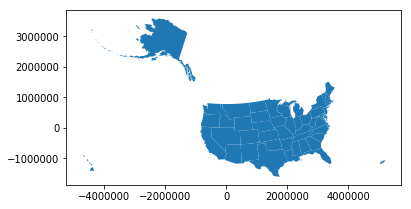

In [62]:
#Repeat with equal-area projection
aea_proj_str = '+proj=aea +lat_1=37.31 +lat_2=46.69 +lat_0=42.00 +lon_0=-114.27 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs '
states_gdf_aea = states_gdf.to_crs(aea_proj_str)
states_gdf_aea.plot()

## Use GeoPandas to create a single Multipolygon for all U.S. State polygons and compute the area
* Need to dissolve on a shared attribute - take a look at the geodataframe, is there anything that all states already have in common?

In [63]:
states_gdf_utm_dissolve = states_gdf_utm.dissolve(by='LSAD')
states_gdf_utm_dissolve = states_gdf_utm.unary_union

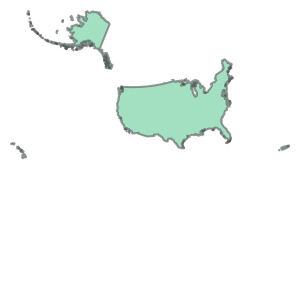

In [64]:
states_gdf_utm_dissolve

In [65]:
states_gdf_utm_dissolve.area

10274972575798.986

## Create plot of GLAS points and overlay the state borders
In order to calculate areas in km2, you should have reprojected the states GeoDataFrame to a projected coordinate system with units of meters.  Hopefully you chose to use the same projected coordinate system you used above for your GLAS point reprojection.  If not, do that now.

* Use your projected coordinate system
* Use the matplotlib object-oriented interface to plot on the same axes:
    * See notes here: https://matplotlib.org/api/api_overview.html
    * The `plot()` function returns a matplotlib.axes object by default
    * Store the output of your geopandas `plot()` call as a new variable called `ax`
    * Note that you no longer see `<matplotlib.axes._subplots.AxesSubplot at 0x7f0da85f5a58>` output in the notebook
    * You can update the axes by modifying the `ax` object
* Make sure you get the plotting order correct, or appropriately set the `facecolor` and `edgecolor` keyword arguments for transparency

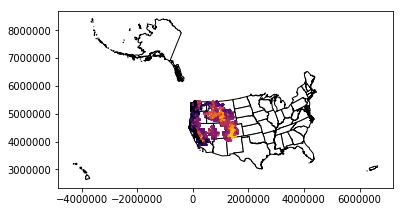

In [66]:
ax = states_gdf_utm.plot(facecolor='white', edgecolor='black')
glas_gdf_utm.plot(ax=ax, column='glas_z', cmap='inferno', markersize=1)
#ax = glas_gdf_utm.plot(column='glas_z', cmap='inferno', markersize=1)
#states_gdf_utm.plot(ax=ax, facecolor='none', edgecolor='black')

## OK, that looks good, but how do we limit to the Western US

### Get the total bounding box (or extent) of the GLAS points
* Hint: this should be easy with geopandas.  But pay attention to the order of values.
* Compute in original lat/lon
* Compute in your chosen projected coordinate system

In [67]:
glas_gdf_bounds = glas_gdf.total_bounds
print(glas_gdf_bounds)
glas_gdf_utm_bounds = glas_gdf_utm.total_bounds
print(glas_gdf_utm_bounds)

[-124.482406   34.999455 -104.052336   48.999727]
[-125690.56336987 3873404.46418299 1625820.66168085 5442460.25167103]


### Create a function to pad the bounds by user-specified distance
* Assume the user knows the units of their projection, and specifies this distance appropriately (e.g., not 20000 degrees)

In [68]:
def pad_bounds(bounds, width):
    return [bounds[0]-width, bounds[1]-width, bounds[2]+width, bounds[3]+width]

In [69]:
print(glas_gdf_utm_bounds)
glas_gdf_utm_bounds = pad_bounds(glas_gdf_utm_bounds, 20000)
print(glas_gdf_utm_bounds)

[-125690.56336987 3873404.46418299 1625820.66168085 5442460.25167103]
[-145690.5633698732, 3853404.464182986, 1645820.661680853, 5462460.251671031]


### Update your GLAS scatterplot and set the x and y limits to your padded bounds

(3853404.464182986, 5462460.251671031)

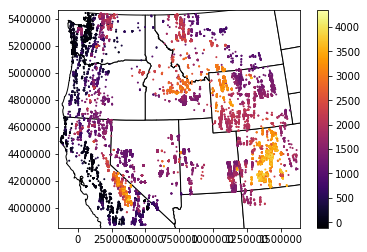

In [70]:
ax = states_gdf_utm.plot(facecolor='white', edgecolor='black')
glas_gdf_utm.plot(ax=ax, column='glas_z', cmap='inferno', markersize=1, legend=True)
ax.set_xlim(glas_gdf_utm_bounds[0], glas_gdf_utm_bounds[2])
ax.set_ylim(glas_gdf_utm_bounds[1], glas_gdf_utm_bounds[3])

# Clip the GLAS points to Washington state polygon
* Extract the Washington geometry from reprojected state GeoDataFrame
    * We can't just reuse the geometry from first part of notebook
* Clip reprojected GLAS point GeoDataFrame with this WA state geometry
* Store valid points in a new geodataframe
* Plot the resulting points and the Washington outline in the projected coordinate system

In [71]:
wa_gdf_utm = states_gdf_utm[states_gdf_utm['NAME'] == 'Washington']
wa_geom_utm = wa_gdf_utm.iloc[0].geometry

In [72]:
glas_gdf_utm_wa = glas_gdf_utm[glas_gdf_utm.intersects(wa_geom_utm)]

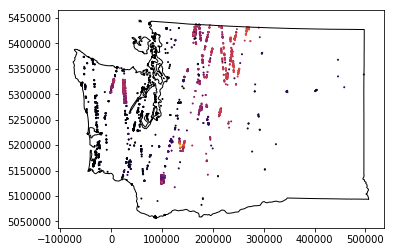

In [73]:
ax = glas_gdf_utm_wa.plot(column='glas_z', cmap='inferno', markersize=1)
ax = wa_gdf_utm.plot(ax=ax, facecolor='none', edgecolor='black')

## Find the GLAS point closest to the centroid of WA state
* Plot the centroid on your WA map
* What is the distance?
* Repeat for you Center of the Universe coordinates

POINT (238665.787088635 5253664.95026295)


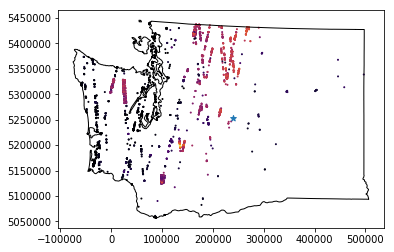

In [81]:
c = wa_gdf_utm.centroid.iloc[0]
print(c)
ax = glas_gdf_utm_wa.plot(column='glas_z', cmap='inferno', markersize=1)
ax = wa_gdf_utm.plot(ax=ax, facecolor='none', edgecolor='black')
wa_gdf_utm.centroid.plot(ax=ax, marker='*')

In [82]:
seattle_geom = Point(cotu_coord)
ax.plot(seattle_geom)

In [83]:
print(glas_gdf_utm_wa.distance(c).min())
minidx = glas_gdf_utm_wa.distance(c).idxmin()
glas_gdf_utm_wa.loc[minidx]

7525.651396041399


decyear                                          2008.94
ordinal                                           733388
lat                                              47.3198
lon                                             -120.493
glas_z                                           1539.35
dem_z                                            1532.48
dem_z_std                                          17.71
lulc                                                  31
geometry     POINT (236012.3704899929 5246622.592043661)
utm_x                                             236012
utm_y                                        5.24662e+06
Name: 61917, dtype: object

In [ ]:
#Another solution to explore
#from shapely.ops import nearest_points
#nearest_point_wa = glas_gdf_utm_wa[gglas_wa.geometry==nearest_points(wa_utm.centroid.geometry.iloc[0],gglas_wa.geometry.unary_union)[1]]

# Extra Credit

Send me a quick message on Slack if you are going to attempt.  Depending on how far we get this week, I may push some of the above exercises and some of the Extra Credit to the Week 5 lab.  

Yuzhou did some nice work on these - https://github.com/UW-GDA/week04-fundamentals-crs-geom-yuzhou-wang/blob/master/04_CRS_Projections_Transformations_GeoPandas_Geometry.ipynb

## Extra Credit (or, other challenging yet interesting problems)

1. See if you can split the ICESat points and create shapely LineString features for each unique track  
    * Note that this information was in the original ICESat dataset, but I removed to reduce file size and complexity
    * What is the longest continuous track?

2. Create a function to automatically compute UTM zone (with appropriate N/S handling) based on input point coordinates

3. Compare your geopandas distances with distances computed using Pythagorean theorem

4. Create a function to identify the 3 closest points to each GLAS point 
    * Then use these 3 points to:
        - Define a plane
        - Calculate the elevation on that planar surface at the original GLAS point coordinates
        - Compute the difference between the interpolate elevation and observed elevation  
        
5. For each GLAS point, compute mean and std for all points within a 10 km radius
    * Can potentially create buffer around the point, then intersect with all points
    * Can compute distance to all points, then threshold

6. Explore some available interpolation methods to create a continuous surface of elevation values from the sparse ICESat points
    * This is mostly for illustration, you wouldn't want to use ICESat for this purpose

7. Integrate the Randolph Glacier Inventory polygons to further clip the ICESat points (https://www.glims.org/RGI/).
    * Buffer by ~1 km, get number of shots for each glacier